In [19]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os

console = genjax.pretty(show_locals=False)

In [20]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=50.0, fy=50.0,
    cx=50.0, cy=50.0,
    near=0.001, far=6.0
)

b.setup_renderer(intrinsics)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/cube.obj"))
model_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv/models")
IDX = 13
mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path_ply, scaling_factor=1.0/100.0)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [29]:
from dataclasses import dataclass
from math import pi

import jax
import jax.numpy as jnp

from genjax._src.generative_functions.distributions.distribution import ExactDensity


@dataclass
class GaussianVMFPose(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_sample(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_logpdf(pose, pose_mean, var, concentration)

@dataclass
class ImageLikelihood(ExactDensity):
    def sample(self, key, rendered_image, variance, outlier_prob, outlier_volume, **kwargs):
        return rendered_image

    def logpdf(self, image, rendered_image, variance, outlier_prob, outlier_volume, **kwargs):
        return b.threedp3_likelihood(image, rendered_image, variance, outlier_prob, outlier_volume,5)

gaussian_vmf_pose = GaussianVMFPose()
image_likelihood = ImageLikelihood()

In [30]:
@genjax.gen
def single_object_floating_pose_model():
    center_pose = b.t3d.transform_from_pos(jnp.array([0.0, 0.0, 1.5]))
    pose = genjax.trace("pose", gaussian_vmf_pose)(center_pose, 0.1, 0.00001)
    rendered_img = b.RENDERER.render_single_object(pose, 0)[:,:,:3]

    variance = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.001) @ "outlier_prob"
    image = genjax.trace("image", image_likelihood)(rendered_img, variance, outlier_prob, 100.0)
    return rendered_img

simulate_jit = jax.jit(single_object_floating_pose_model.simulate)
importance_jit = jax.jit(single_object_floating_pose_model.importance)
importance_parallel_jit = jax.jit(jax.vmap(single_object_floating_pose_model.importance, in_axes=(0, None, None)))

In [32]:
key = jax.random.PRNGKey(100)

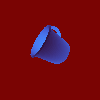

In [50]:
key, gt_trace= simulate_jit(key, ())
observed_image = gt_trace.get_retval()
observation = genjax.choice_map({"image": observed_image})
# print(gt_trace.get_choices())
b.get_depth_image(observed_image[:,:,2])

[7339 7339 7339 7339 7339 7339 7339 7339 7339 7339]
[17874.074 17874.074 17874.074 17874.074 17874.074 17874.074 17874.074
 17874.074 17874.074 17874.074]


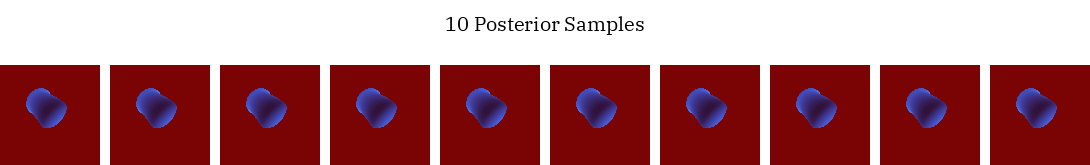

In [62]:
num_samples = 8000
keys = jax.random.split(key, num_samples)
key = keys[0]
keys, (weights, traces) = importance_parallel_jit(keys, observation, ())
sampled_indices = jax.random.categorical(key, weights, shape=(10,))
print(sampled_indices)
print(weights[sampled_indices])
images = [b.get_depth_image(img[:,:,2]) for img in traces.get_retval()[sampled_indices]]
b.multi_panel(images,title="10 Posterior Samples", title_fontsize=20)

[1629 1629 1629 1629 1629 1629 1629 1629 1629 1629]
[27338.492 27338.492 27338.492 27338.492 27338.492 27338.492 27338.492
 27338.492 27338.492 27338.492]


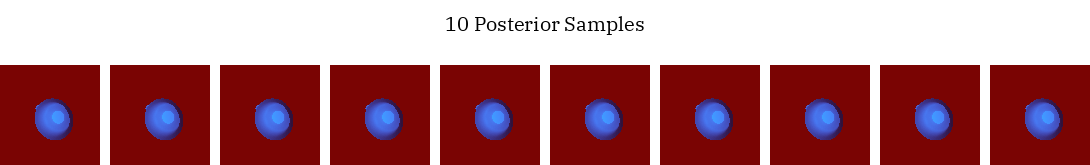